In [60]:
import json
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv

In [61]:
json_file = 'elyzee_data/elyzee_train.json'
graph_train_networkx = nx.node_link_graph(json.load(open(json_file)))

json_file = 'elyzee_data/elyzee_test.json'
graph_test_networkx = nx.node_link_graph(json.load(open(json_file)))

In [62]:
num_classes = 7
labels_dict = {
    'lr': 0, 
    'em': 1, 
    'fn': 2, 
    'fi': 3, 
    'ps': 4,
    'multi_affiliations': 5, 
    'indetermined': 6
}
node_id = list(graph_train_networkx.nodes)[0]
num_features = len(graph_train_networkx.nodes[node_id]['features'])

In [63]:
graph_train_torch = from_networkx(graph_train_networkx)
graph_test_torch = from_networkx(graph_test_networkx)
print("Train :",graph_train_torch)
print("Test :",graph_test_torch)

Train : Data(edge_index=[2, 19284], features=[5507, 999], affiliation=[5507], num_nodes=5507)
Test : Data(edge_index=[2, 6402], features=[2222, 999], affiliation=[2222], num_nodes=2222)


In [64]:
graph_train_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_train_torch.affiliation]
)).float()
graph_test_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_test_torch.affiliation]
)).float()
print("Train labels :", graph_train_torch.labels.shape)
print("Test labels :", graph_test_torch.labels.shape)


Train labels : torch.Size([5507, 7])
Test labels : torch.Size([2222, 7])


In [143]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()

        # Initialize the layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Dense layer
        x = self.linear(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [164]:
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.01
    decay = 5e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_test = []
    list_train_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features, graph_train.edge_index)
        # Compute loss
        loss_train = criterion(logits_train, graph_train.labels) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train, dim=1) == torch.argmax(graph_train.labels, dim=1)).float().mean()
        list_train_acc.append(train_acc)
        
        
        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                logits_test = model(graph_test.features, graph_test.edge_index)
                loss_test = criterion(logits_test, graph_test.labels)
                list_loss_test.append(loss_test.item())
                test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
                list_test_acc.append(test_acc)
                print('Epoch %d | Loss Train : %.4f | Train Accuracy : %.4f | Loss Test: %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), train_acc, loss_test.item(), test_acc))
                
    return list_loss_train, list_loss_test, list_train_acc, list_test_acc

In [167]:
model = GCN(hidden_channels=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model,
    graph_train_torch,
    graph_test_torch,
    200
)

Epoch 0 | Loss Train : 1.9468 | Train Accuracy : 0.1251 | Loss Test: 1.9387 | Test Accuracy: 0.1899
Epoch 1 | Loss Train : 1.9261 | Train Accuracy : 0.2232 | Loss Test: 1.9161 | Test Accuracy: 0.1890
Epoch 2 | Loss Train : 1.9078 | Train Accuracy : 0.2128 | Loss Test: 1.9055 | Test Accuracy: 0.1701
Epoch 3 | Loss Train : 1.8948 | Train Accuracy : 0.2123 | Loss Test: 1.8977 | Test Accuracy: 0.2286
Epoch 4 | Loss Train : 1.8595 | Train Accuracy : 0.3022 | Loss Test: 1.8692 | Test Accuracy: 0.3452
Epoch 5 | Loss Train : 1.8017 | Train Accuracy : 0.3743 | Loss Test: 1.8198 | Test Accuracy: 0.3735
Epoch 6 | Loss Train : 1.7714 | Train Accuracy : 0.3795 | Loss Test: 1.7907 | Test Accuracy: 0.3650
Epoch 7 | Loss Train : 1.7299 | Train Accuracy : 0.4058 | Loss Test: 1.7894 | Test Accuracy: 0.3852
Epoch 8 | Loss Train : 1.7250 | Train Accuracy : 0.4265 | Loss Test: 1.7510 | Test Accuracy: 0.3713
Epoch 9 | Loss Train : 1.7058 | Train Accuracy : 0.4211 | Loss Test: 1.7399 | Test Accuracy: 0.3830


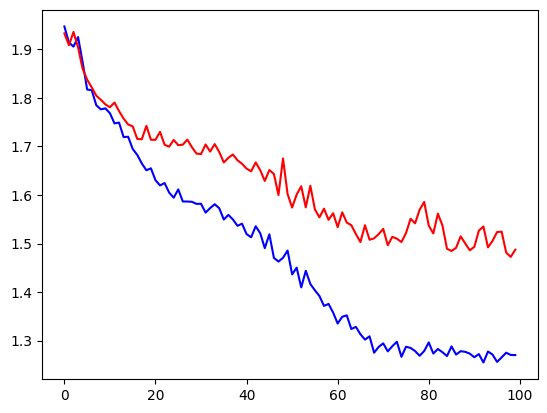

In [162]:
import matplotlib.pyplot as plt

plt.plot(list_loss_train, color='blue')
plt.plot(list_loss_test, color='red')

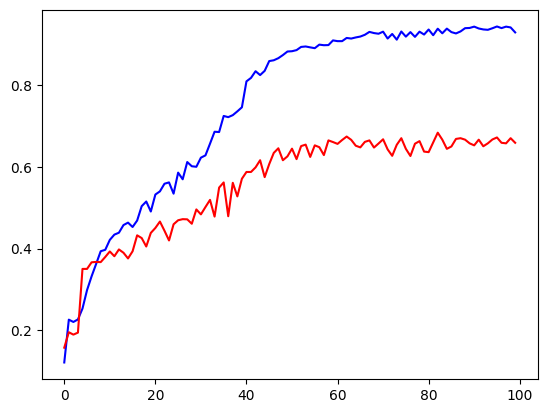

In [153]:
plt.plot(list_train_acc, color='blue')
plt.plot(list_test_acc, color='red')

In [138]:
graph_train_torch.labels[0].shape

torch.Size([7])

In [141]:
[ sum(graph_train_torch.labels[:,i]) for i in range(7) ]

[tensor(686.),
 tensor(646.),
 tensor(686.),
 tensor(1158.),
 tensor(599.),
 tensor(840.),
 tensor(892.)]

In [142]:
[ sum(graph_test_torch.labels[:,i]) for i in range(7) ]

[tensor(322.),
 tensor(275.),
 tensor(276.),
 tensor(420.),
 tensor(284.),
 tensor(319.),
 tensor(326.)]